In [1]:
from footprints import KljunFootprint

In [1]:
import pickle as p
import numpy as np

data = p.load(open('results/ec_data_object.p', 'rb'))
(X, Y, mean_flux) = p.load(open('results/mean_sgs_flux.p', 'rb'))
bounds = [np.min(X)-2.5, np.max(X)+2.5, np.min(Y)-2.5, np.max(Y)+2.5]
de = 5.0
measured_flux = data.data_structure['co2_flux']
time = data.time

In [3]:
zm = 6.0
h = 1000.0
z0 = 0.03

In [2]:
from datetime import datetime
index = np.where(np.logical_and(time > np.datetime64(datetime(2015, 6, 1)), time <= np.datetime64(datetime(2016, 6, 1))))[0]

In [5]:
import csv
time_snow = []
snow_depth = []

with open('data/footprint/snow20152016.csv', 'r', encoding = 'utf-8-sig') as file:
    reader = csv.reader(file)
    for row in reader:
        time_snow += [datetime(int(row[0]), int(row[1]), int(row[2]))]
        snow_depth += [float(row[3])]
time_snow = np.array(time_snow, dtype = np.datetime64)
snow_depth = np.array(snow_depth) / 100.0

In [6]:
def estimate_snow_depth(t):
    i = np.where(np.abs(time_snow - np.datetime64(t)) == np.min(np.abs(time_snow - np.datetime64(t))))
    return snow_depth[i]

In [7]:
calculated_flux = np.zeros((len(index),))

for i, j in enumerate(index):
    L = data.data_structure['L'][j]
    ustar = data.data_structure['ustar'][j]
    sigma_v = data.data_structure['v_sd'][j]
    wind_dir = data.data_structure['wind_dir'][j]
    delta_zm = estimate_snow_depth(time[j])

    fp = KljunFootprint(z0, zm-delta_zm[0], L, ustar, sigma_v, wind_dir, h)
    fp.bounds = bounds
    fp.de = de
    fp.calculate_footprint()
    calculated_flux[i] = np.nansum(fp.footprint*mean_flux*np.power(de,2.0))

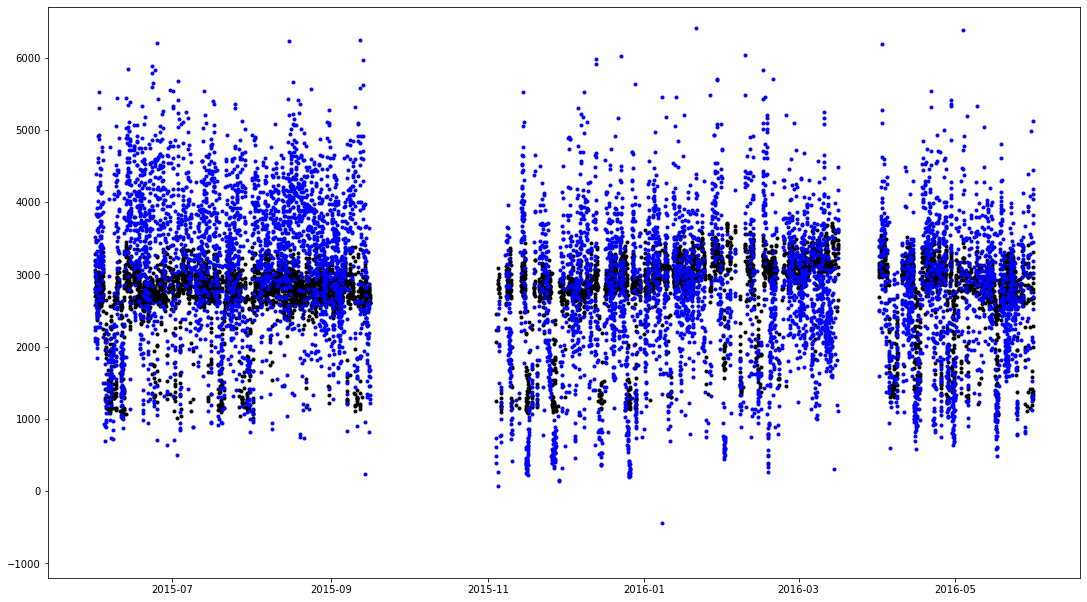

In [8]:
import matplotlib.pylab as plt

plt.plot(time[index], calculated_flux, 'k.')
plt.plot(time[index], data.co2_flux[index], 'b.')
axis = list(plt.gca().axis())
axis[2:] = [-1200.0, 6700.0]
plt.gca().axis(axis)
plt.gcf().set_size_inches(18.5, 10.5)

In [9]:
time_calculated = time[index]

import pickle as p
p.dump((time_calculated, calculated_flux), open('results/calculated_flux_based_on_footprints.p', 'wb')) 

In [3]:
import pickle as p
(time_calculated, calculated_flux) = p.load(open('results/calculated_flux_based_on_footprints.p', 'rb'))

In [4]:
# Double time-series length for smoothing and fitting exercise:

time_2x = np.hstack((time_calculated, time_calculated + np.timedelta64(1, 'Y').astype('timedelta64[s]')))
calculated_flux_2x = np.hstack((calculated_flux, calculated_flux))
observed_flux_2x = np.hstack((data.co2_flux[index], data.co2_flux[index]))

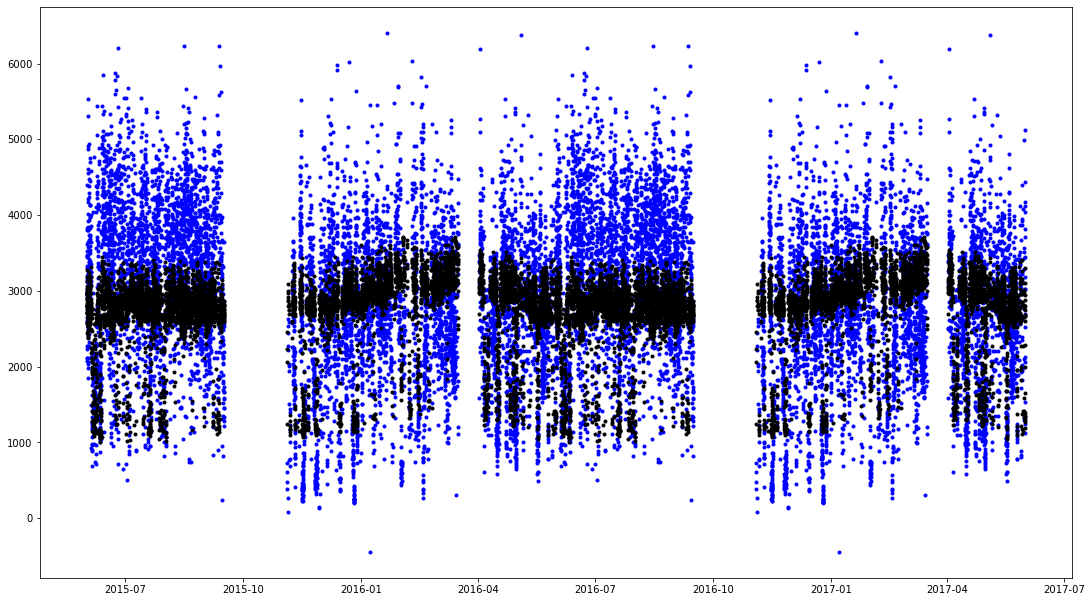

In [6]:
import matplotlib.pyplot as plt

plt.plot(time_2x, observed_flux_2x, 'b.')
plt.plot(time_2x, calculated_flux_2x, 'k.')

plt.gcf().set_size_inches(18.5, 10.5)

In [7]:
def gaussian_filter(time, data):
    
    time_decimal_day = (time - np.min(time)).astype('timedelta64[s]').astype(np.float64) / (60.0*60.0*24.0)
        
    def inner_function(wavelength_in_days):
        
        def calculate_values(t0):
            tn = (time_decimal_day - t0) / wavelength_in_days
            i = np.where(np.logical_and(tn > -5, tn < 5))
            weights = np.exp(-0.5*np.power(tn[i],2))
            weights /= np.sum(weights)
            return np.sum(data[i]*weights)
    
        return np.vectorize(calculate_values)(time_decimal_day)
    
    return inner_function

In [8]:
my_filter_calc = gaussian_filter(time_2x, calculated_flux_2x)
calculated_flux_2x_smoothed = my_filter_calc(30.0)

my_filter_obs = gaussian_filter(time_2x, observed_flux_2x)
observed_flux_2x_smoothed = my_filter_obs(30.0)

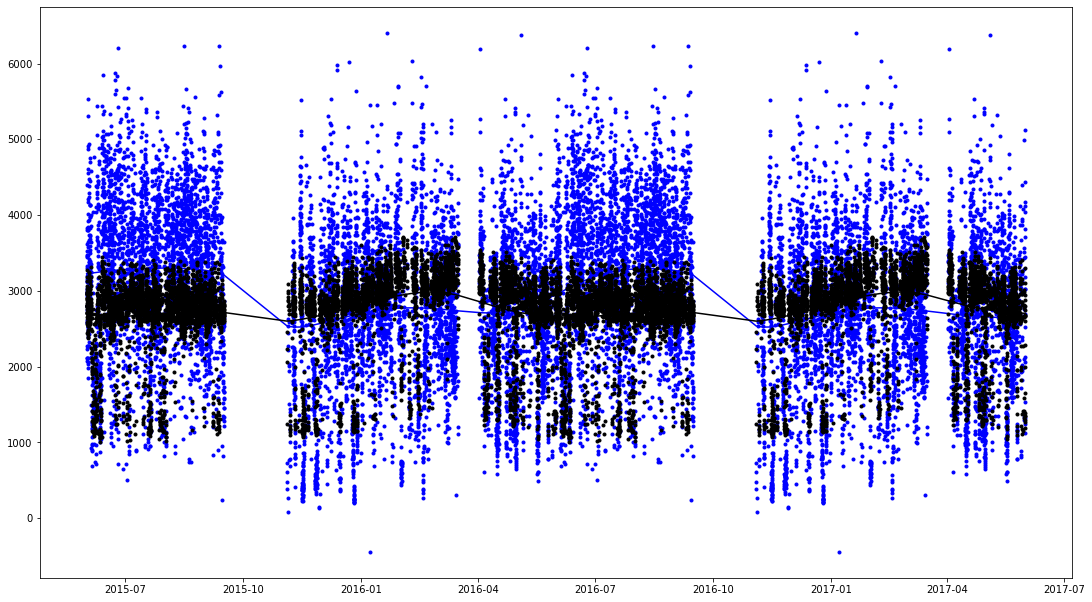

In [9]:
plt.plot(time_2x, observed_flux_2x, 'b.')
plt.plot(time_2x, observed_flux_2x_smoothed, 'b-')
plt.plot(time_2x, calculated_flux_2x, 'k.')
plt.plot(time_2x, calculated_flux_2x_smoothed, 'k-')

plt.gcf().set_size_inches(18.5, 10.5)

In [10]:
def periodic_signal(t, wl):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(A1, A2):
        return A1 * np.cos(2.0*np.pi*t_days/wl) + A2 * np.sin(2.0*np.pi*t_days/wl)
    
    return inner_function

In [11]:
def total_signal(t, wl1, wl2, wl3):
    
    periodic1 = periodic_signal(t, wl1)
    periodic2 = periodic_signal(t, wl2)
    periodic3 = periodic_signal(t, wl3)
        
    def inner_function(x):
        (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b) = x
        return periodic1(A1s1, A2s1) + periodic2(A1s2, A2s2) + periodic3(A1s3, A2s3) + b
    
    return inner_function

In [12]:
def model_misfit(t, co2_flux_obs, wl1, wl2, wl3):
    
    model = total_signal(t, wl1, wl2, wl3)
    
    def inner_function(x):
        return np.sum(np.power(model(x) - co2_flux_obs, 2))
    
    return inner_function

In [13]:
wl1 = 0.5
wl2 = 1.0
wl3 = 365.0

In [14]:
A1s1 = 1000.0
A2s1 = 500

A1s2 = 1000.0
A2s2 = 500

A1s3 = 2000.0
A2s3 = 0

b = 3000.0

x0 = (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b)

from scipy.optimize import fmin

optimize_function_obs = model_misfit(time_2x, observed_flux_2x, wl1, wl2, wl3)
x_obs = fmin(optimize_function_obs, x0, maxfun = 1E12)

optimize_function_calc = model_misfit(time_2x, calculated_flux_2x, wl1, wl2, wl3)
x_calc = fmin(optimize_function_calc, x0, maxfun = 1E12)

Optimization terminated successfully.
         Current function value: 15729972769.927147
         Iterations: 1367
         Function evaluations: 2061
Optimization terminated successfully.
         Current function value: 3660966388.643315
         Iterations: 1250
         Function evaluations: 1892


302.6231076046884


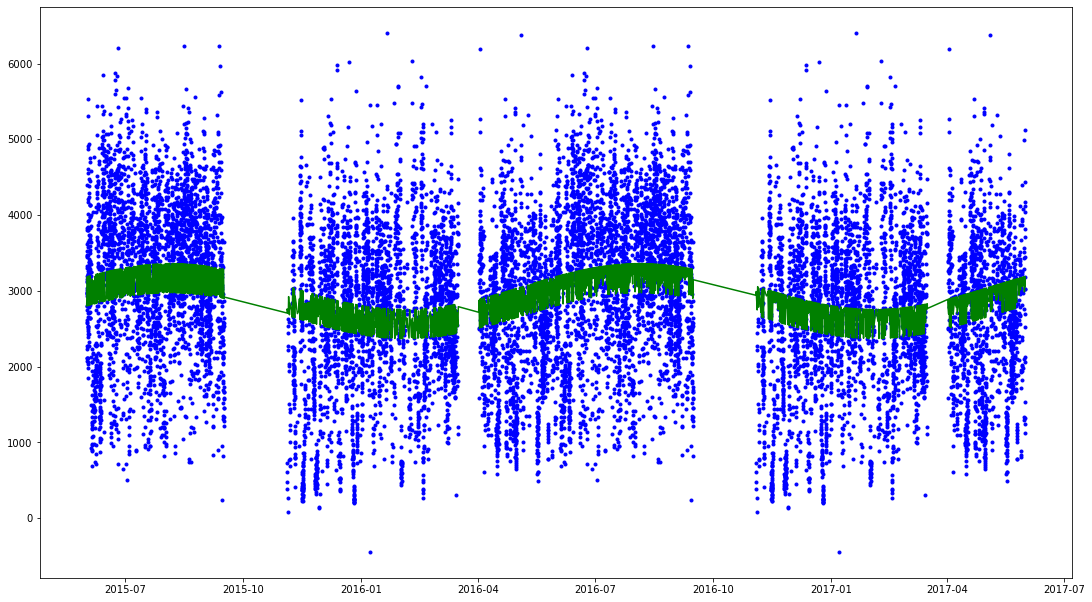

In [15]:
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b) = x_obs

model = total_signal(time_2x, wl1, wl2, wl3)

co2_obs = model(x_obs)

plt.plot(time_2x, observed_flux_2x,'b.')
plt.plot(time_2x, co2_obs,'g-')
plt.gcf().set_size_inches(18.5, 10.5)
print(np.sqrt(np.sum(np.power(x_obs[-3:-1],2))))

142.43636956828956


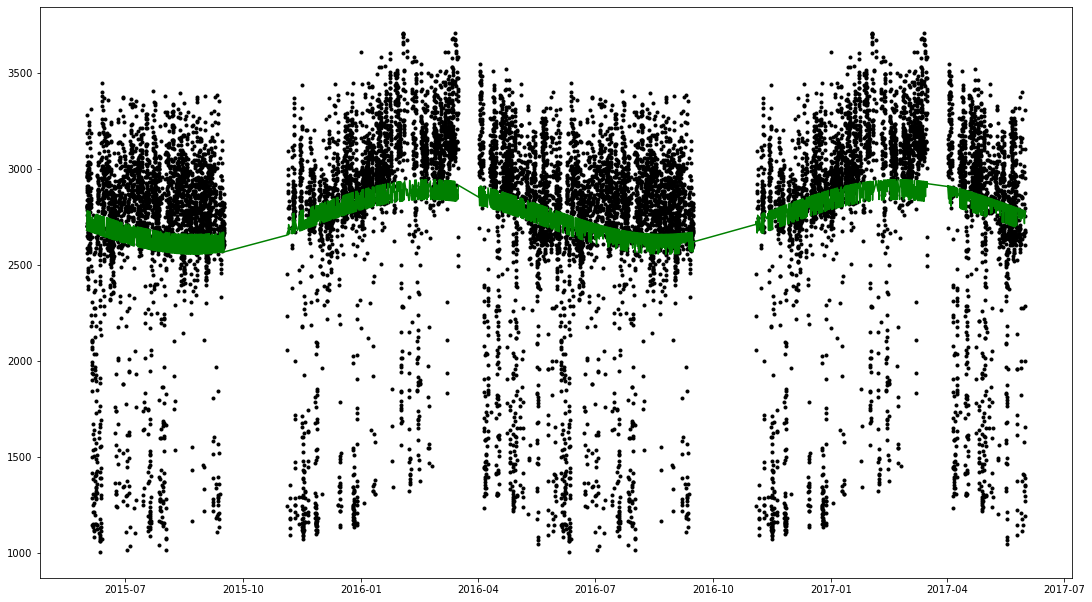

In [16]:
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b) = x_calc

model = total_signal(time_2x, wl1, wl2, wl3)

co2_calc = model(x_calc)

plt.plot(time_2x, calculated_flux_2x,'k.')
plt.plot(time_2x, co2_calc,'g-')
plt.gcf().set_size_inches(18.5, 10.5)
print(np.sqrt(np.sum(np.power(x_calc[-3:-1],2))))

In [17]:
print('Phase of observed: ', np.rad2deg(np.arctan2(x_obs[-2], x_obs[-3])))
print('Phase of calculated: ', np.rad2deg(np.arctan2(x_calc[-2], x_calc[-3])))
print('Phase difference: ', np.rad2deg(np.arctan2(x_obs[-2], x_obs[-3]))-np.rad2deg(np.arctan2(x_calc[-2], x_calc[-3])))

Phase of observed:  64.82902605796097
Phase of calculated:  -97.42579514722006
Phase difference:  162.25482120518103


In [18]:
print('Observed average flux: ', x_obs[-1])

Observed average flux:  2874.220731429268


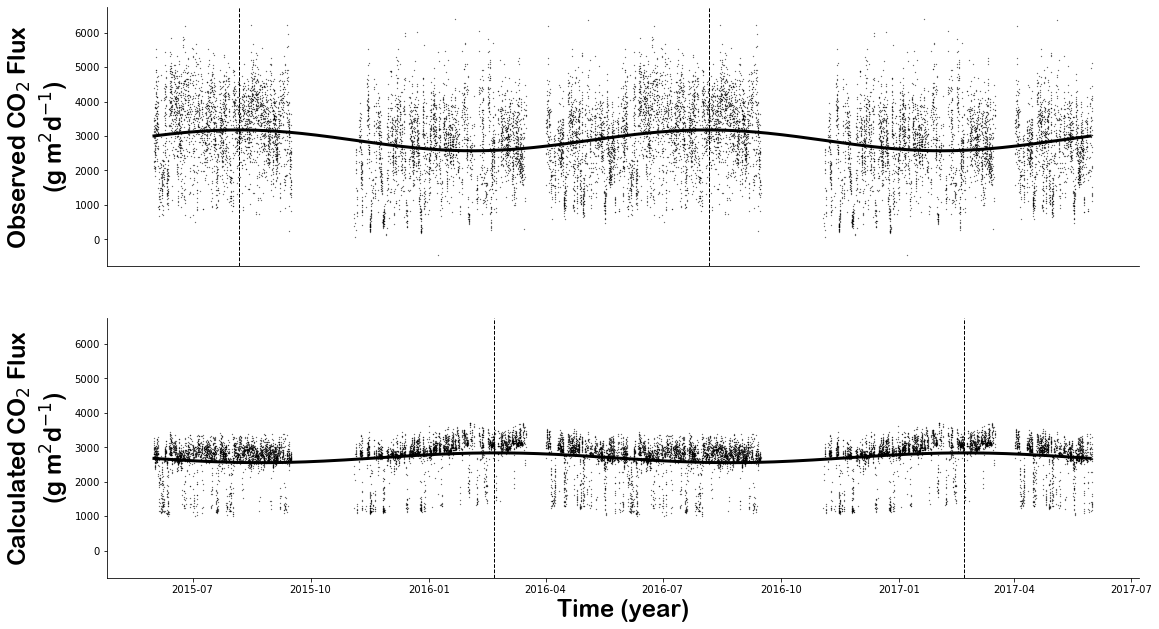

In [57]:
from utils import daterange
from datetime import datetime

plt.figure()
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.subplot(2,1,1)
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b) = x_obs
x_obs[0:4] = 0.0

t_mod = np.array(list(daterange(datetime(2015, 6, 1), datetime(2017, 5, 31))), dtype = np.datetime64)

model = total_signal(t_mod, wl1, wl2, wl3)

co2_obs = model(x_obs)

plt.plot(time_2x, observed_flux_2x,'k.', markersize=0.5)
plt.plot(t_mod, co2_obs,'k-', linewidth = 3)
#plt.gca().set_yticklabels(plt.gca().get_yticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 14})
plt.ylabel('Observed CO$_{2}$ Flux \n(g m$^{2}$d$^{-1}$)', fontname = "Arial Rounded MT Bold", fontsize = 24)
plt.gca().get_xaxis().set_visible(False)
plt.axis('tight')
ax = plt.axis()
i = np.where(co2_obs == np.max(co2_obs))
plt.plot([t_mod[i][0], t_mod[i][0]],[ax[2], ax[3]], 'k--', linewidth = 1 )
plt.plot([np.datetime64(datetime(2016, 8, 6)), np.datetime64(datetime(2016, 8, 6))],[ax[2], ax[3]], 'k--', linewidth = 1)
plt.axis(ax)
plt.subplot(2,1,2)
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, b) = x_calc

model = total_signal(t_mod, wl1, wl2, wl3)

co2_calc = model(x_calc)

plt.plot(time_2x, calculated_flux_2x,'k.', markersize = 0.5)
plt.plot(t_mod, co2_calc,'k-', linewidth = 3)

i = np.where(co2_calc == np.max(co2_calc))
plt.plot([t_mod[i][0], t_mod[i][0]],[ax[2], ax[3]], 'k--', linewidth = 1 )
plt.plot([np.datetime64(datetime(2016, 2, 21)), np.datetime64(datetime(2016, 2, 21))],[ax[2], ax[3]], 'k--', linewidth = 1)
plt.axis(ax)

plt.xlabel('Time (year)', fontname = "Arial Rounded MT Bold", fontsize = 24)
plt.ylabel('Calculated CO$_{2}$ Flux \n(g m$^{2}$d$^{-1}$)', fontname = "Arial Rounded MT Bold", fontsize = 24)


plt.gcf().set_size_inches(18.5, 10.5)
plt.savefig('results/Figure3.eps', format='eps')

